# Biotic anthropogenic classification

Aim is to classify each moment in time as being:
    
- biotic/not biotic
- anthropogenic/not anthropogenic


We will use a separate model for each of these classifications

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import csv
import os
import numpy as np
import collections

import scipy.io.wavfile
from scipy.io import loadmat
from sklearn.cross_validation import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.cross_validation import train_test_split
import collections
from scipy.ndimage.interpolation import zoom

import sys, os
sys.path.append(os.path.expanduser('~/projects/engaged_hackathon/'))
from engaged.features import features as engaged_features
from engaged.features import frequency


In [2]:
# getting a list of all the files
base_path = '/home/michael/projects/engaged_hackathon_data/raw_data/one_minute_files'
files = os.listdir(base_path + '/detection_challenge')
files = [xx.split('.')[0] for xx in files]

spectrogram_parameters = {
    'nfft': 1024,
    'window_width': 0.03,
    'overlap': 0.01,
    }

print len(files)

362


## Computing all the features and saving to disk

In [3]:
# for each file, compute features for each second and assign to biotic/not_biotic lists
# we will worry about anthropogenic later
max_files = 50

# maximum num slices of each class to take from each file
max_from_each_file = 500
files_to_use = files[:max_files]

features_savepath = '/home/michael/projects/engaged_hackathon_data/detection/biotic_anthrop/'


def choose_locations(idxs, maximum, balance=False):
    """
    Given a binary array, the function returns a list of positive and negative locations sampled
    at random from the list.
    Returns 'maximum' locations unless there there are fewer than maximum locations in
    idxs, in which case all are returned
    If balance is true then the classes are balanced to the smaller class size to
    ensure an equal number of each
    """
    false_idxs = np.where(idxs==0)[0]
    true_idxs = np.where(idxs==1)[0]
    
    if false_idxs.shape[0] > maximum and maximum is not None:
        false_idxs = np.random.choice(false_idxs, maximum, replace=False)
        
    if true_idxs.shape[0] > maximum and maximum is not None:
        true_idxs = np.random.choice(true_idxs, maximum, replace=False)
        
    if false_idxs.shape[0] != true_idxs.shape[0] and balance:
        raise Exception("Not implemented!")
        
    return true_idxs, false_idxs
    

def extract_features(spec, binary_idxs, maximum=None):
    """
    returns a set of features from the spectrogram at points marked by idxs.
    If there are more idx locations than maximum, then will subsample idxs.
    """
    true_idxs, false_idxs = choose_locations(binary_idxs, maximum)
    idxs = np.hstack([true_idxs, false_idxs])
    labels = np.hstack(
        [np.ones(true_idxs.shape), np.zeros(false_idxs.shape)])
    N = idxs.shape[0]
    
    max_pos = np.argmax(spec[:, idxs], axis=0)[:, None]
    max_val = np.max(spec[:, idxs], axis=0)[:, None]

    # take the maximum, mean, var across strips surrounding each idx
    substrip_means = [] #np.zeros((6*new_height))]
    substrip_maxs = []#np.zeros((6*new_height))]
    substrip_vars = []#np.zeros((6*new_height))]
    med_features = []
    max_features = []

    for idx in idxs:
        substrip = np.take(spec[:-1, :], [idx-3, idx-2, idx-1, idx, idx+1, idx+2, idx+3], mode='clip', axis=1)
        substrip_reshaped = substrip.T.reshape((-1, 7*8))

        substrip_maxs.append(substrip_reshaped.max(axis=0))
        substrip_means.append(substrip_reshaped.mean(axis=0))
        substrip_vars.append(substrip_reshaped.var(axis=0))

        sampled_spec = spec[:-1, idx]
        max_features.append(sampled_spec.reshape((-1, 8)).max(axis=1).T)
        med_features.append(np.median(sampled_spec.reshape((-1, 8)), axis=1).T)
    
    substrip_maxs = np.vstack(substrip_maxs)
    substrip_means = np.vstack(substrip_means)
    substrip_vars = np.vstack(substrip_vars)
    med_features = np.vstack(med_features)
    max_features = np.vstack(max_features)

    return {
        'max_val': max_val,
        'max_pos': max_pos,
        'max_features': max_features,
        'med_features': med_features,
        'substrip_maxs': substrip_maxs,
        'substrip_vars': substrip_vars,
        'substrip_means': substrip_means,
        'num_idxs': N,
        'single_strip': spec[:, idxs].T,
        'idxs': idxs,
        'labels': labels
    }

# max_features, med_features, max_pos,  

def process_file(inputs):
    
    count, fname = inputs
    
    # load in wav and convert to spectrogram
    sr, wav = scipy.io.wavfile.read(base_path + '/25_Random/' + fname + '.wav')  
    spec, spec_sample_rate = frequency.spectrogram(wav, sr, **spectrogram_parameters)
    spec -= np.median(spec, axis=1)[:, None]
#     spec[spec < 0] = 0
        
    # load in ground truth
    gt = loadmat(base_path + '/detection_challenge/' + fname + '.mat')
    
    # convert the labels to the sampling rate of the spectrogram
    zoom_factor = float(spec.shape[1]) / float(wav.shape[0])
    gt_biotic = zoom(gt['biotic'][0], zoom_factor).astype(bool)
    gt_anthrop = zoom(gt['anthropogenic'][0], zoom_factor).astype(bool)
        
    # group spec slices according to labels
    these_data = {}
    
    # let's group the X here and create a suitable Y vector...
    XY = extract_features(spec, gt_biotic, max_from_each_file)
    savepath = features_savepath + fname + '_biotic.mat'
    scipy.io.savemat(savepath, XY, do_compression=True)
    
    XY = extract_features(spec, gt_anthrop, max_from_each_file)
    savepath = features_savepath + fname + '_anthrop.mat'
    scipy.io.savemat(savepath, XY, do_compression=True)

    if count % 5 == 0:
        print count,

if True:
    import multiprocessing
    import functools
    pool = multiprocessing.Pool(8)
    pool.map(process_file, enumerate(files_to_use))
else:
    map(process_file, enumerate(files_to_use))


10 0 20 15 

In [4]:
# splitting into train and test sets
train_files, test_files = train_test_split(files_to_use, random_state=0)

## Compiling together the features for each experiment

In [31]:
class_to_use = 'biotic'

experiments = collections.OrderedDict([
    ('max_val', ['max_val']),
    ('max_pos', ['max_pos']),
    ('max_features', ['max_features']),
    ('med_features', ['med_features']),
    ('substrip_maxs', ['substrip_maxs']),
    ('substrip_vars', ['substrip_vars']),
    ('substrip_means', ['substrip_means']),
    ('all_single_strips', ['max_val', 'max_pos', 'max_features', 'med_features']),
    ('single_strip', ['single_strip']),
    ('all_substrips', ['substrip_maxs', 'substrip_vars', 'substrip_means'])
])

train_Y = []
train_X = collections.defaultdict(list)
test_Y = []
test_X = collections.defaultdict(list)

# loop over each *file* first, this minimises I/O time
for fname in train_files:
    
    # load in the data
    these_data = scipy.io.loadmat(features_savepath + fname + '_' + class_to_use + '.mat')
    train_Y.append(these_data['labels'])
        
    for experiment_name, features in experiments.iteritems():
        temp = [these_data[feature] for feature in features]
        train_X[experiment_name].append(np.hstack(temp))

train_Y = np.hstack(train_Y).ravel()

# loop over each *file* first, this minimises I/O time
for fname in test_files:
    
    # load in the data
    these_data = scipy.io.loadmat(features_savepath + fname + '_' + class_to_use + '.mat')
    test_Y.append(these_data['labels'])
        
    for experiment_name, features in experiments.iteritems():
        temp = [these_data[feature] for feature in features]
        test_X[experiment_name].append(np.hstack(temp))

test_Y = np.hstack(test_Y).ravel()

        
print np.hstack(train_Y).shape
print train_X['all_substrips'][0].shape
print np.vstack(train_X['max_features']).shape
print np.vstack(train_X['all_substrips']).shape

for xx in train_X.keys():
    train_X[xx] = np.vstack(train_X[xx])
    
for xx in test_X.keys():
    test_X[xx] = np.vstack(test_X[xx])
    
# now let's balance the classes...
def balance_classes(X, Y):
    positives = np.where(Y == 0)[0]
    negatives = np.where(Y == 1)[0]
    max_examples = min(len(positives), len(negatives))
    if len(positives) > max_examples:
        positives = np.random.choice(positives, max_examples, replace=False)
    if len(negatives) > max_examples:
        negatives = np.random.choice(negatives, max_examples, replace=False)
    for key in X.keys():
        X[key] = np.vstack((X[key][negatives, :], X[key][positives, :]))
    new_Y = np.hstack((Y[negatives], Y[positives])) 
    return X, new_Y

train_X, train_Y = balance_classes(train_X, train_Y)
test_X, test_Y = balance_classes(test_X, test_Y)

print train_Y.sum(), train_Y.shape, train_X['all_substrips'].shape
print test_Y.sum(), test_Y.shape, test_X['all_substrips'].shape
        


(25528,)
(500, 168)
(25528, 64)
(25528, 168)
7028.0 (14056,) (14056, 168)
2000.0 (4000,) (4000, 168)


## Running each experiment with different feature sets

In [43]:
from sklearn.ensemble import RandomForestClassifier

predictions = collections.OrderedDict()
rfs = {}

for experiment_name, features in experiments.iteritems():
    
    print "Training for ", experiment_name
    
    temp_train_X = np.vstack(train_X[experiment_name])
    rf = RandomForestClassifier(n_estimators=50, n_jobs=8, max_features=None)
    rf.fit(temp_train_X, train_Y)
    
    print "Testing for ", experiment_name
    temp_test_X = np.vstack(test_X[experiment_name])
    predictions[experiment_name] = rf.predict_proba(temp_test_X)
   
    rfs[experiment_name] = rf

Training for  max_val
Testing for  max_val
Training for  max_pos
Testing for  max_pos
Training for  max_features
Testing for  max_features
Training for  med_features
Testing for  med_features
Training for  substrip_maxs
Testing for  substrip_maxs
Training for  substrip_vars
Testing for  substrip_vars
Training for  substrip_means
Testing for  substrip_means
Training for  all_single_strips
Testing for  all_single_strips
Training for  single_strip
Testing for  single_strip
Training for  all_substrips
Testing for  all_substrips


## Viewing results

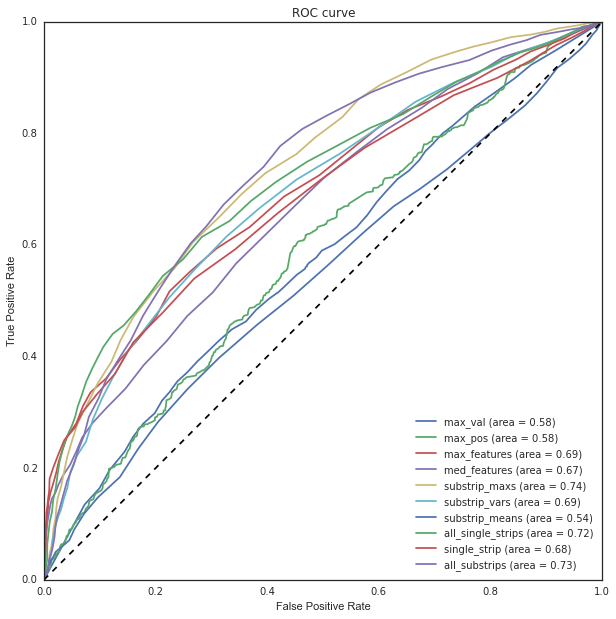

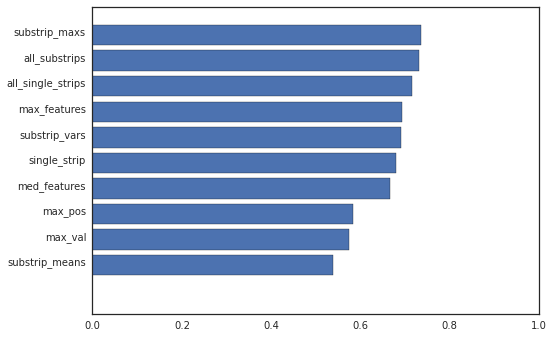

In [33]:
from sklearn.metrics import roc_curve, auc

# Potting an ROC curve for each feature set
aucs = []

plt.figure(figsize=(10, 10))
for experiment_name, pred in predictions.iteritems():
    # plotting this line
    fpr, tpr, _ = roc_curve(test_Y, pred[:, 1].ravel())
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr , label='%s (area = %0.2f)' % (experiment_name, roc_auc))
    
    # saving the auc
    aucs.append((experiment_name, roc_auc))
    
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve')
plt.legend(loc="lower right")
plt.gca().set_aspect('equal', adjustable='box')

# Bar chart of the AUC for each feature set
plt.figure()
aucs.sort(key=lambda x: x[1])
plt.barh(np.arange(len(aucs))-0.5, [xx[1] for xx in aucs])
plt.yticks(np.arange(len(aucs)))
plt.gca().set_yticklabels([xx[0] for xx in aucs]);
plt.xlim(0, 1);

## Confusion matrix for a single feature set

[[1372  628]
 [ 700 1300]]


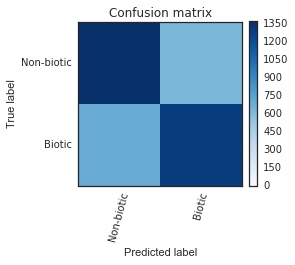

In [34]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
sns.set_style("white")

labels = ['Non-biotic', 'Biotic']
featureset = 'substrip_maxs'

pred_Y = (predictions[featureset][:, 1]>0.5).astype(int)
cm = confusion_matrix(test_Y, pred_Y)

def plot_confusion_matrix(cm, title='Confusion matrix', cmap=plt.cm.Blues):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar(fraction=0.046, pad=0.04)
    tick_marks = np.arange(len(labels))
    plt.xticks(tick_marks, labels, rotation=75)
    
    plt.yticks(tick_marks, labels)
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

print cm
plt.figure(figsize=(4, 4))
plot_confusion_matrix(cm);
plt.clim(0, cm.max())

## Accuracy scores for one experiment

In [35]:
from sklearn.metrics import classification_report, accuracy_score

print classification_report(test_Y, pred_Y)

print "Accuracy is ", accuracy_score(test_Y, pred_Y)

             precision    recall  f1-score   support

        0.0       0.66      0.69      0.67      2000
        1.0       0.67      0.65      0.66      2000

avg / total       0.67      0.67      0.67      4000

Accuracy is  0.668


In [36]:
print test_Y.shape, test_Y.sum()
print train_Y.shape, train_Y.sum()

(4000,) 2000.0
(14056,) 7028.0


## Predict for a single file and view the performance per slice...

In [ ]:
fname = test_files[0]


# load in wav and convert to spectrogram
sr, wav = scipy.io.wavfile.read(base_path + '/25_Random/' + fname + '.wav')  
spec, spec_sample_rate = frequency.spectrogram(wav, sr, **spectrogram_parameters)
spec -= np.median(spec, axis=1)[:, None]
#     spec[spec < 0] = 0

# load in ground truth
gt = loadmat(base_path + '/detection_challenge/' + fname + '.mat')

# convert the labels to the sampling rate of the spectrogram
zoom_factor = float(spec.shape[1]) / float(wav.shape[0])
gt_biotic = zoom(gt['biotic'][0], zoom_factor).astype(bool)

# extract features
idxs = np.ones(gt_biotic.shape[0])
features = extract_features(spec, idxs)

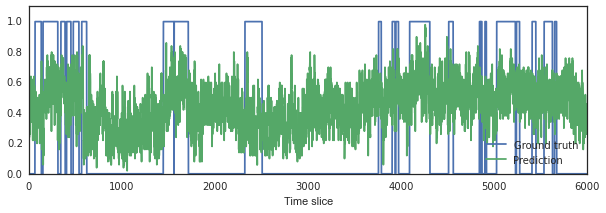

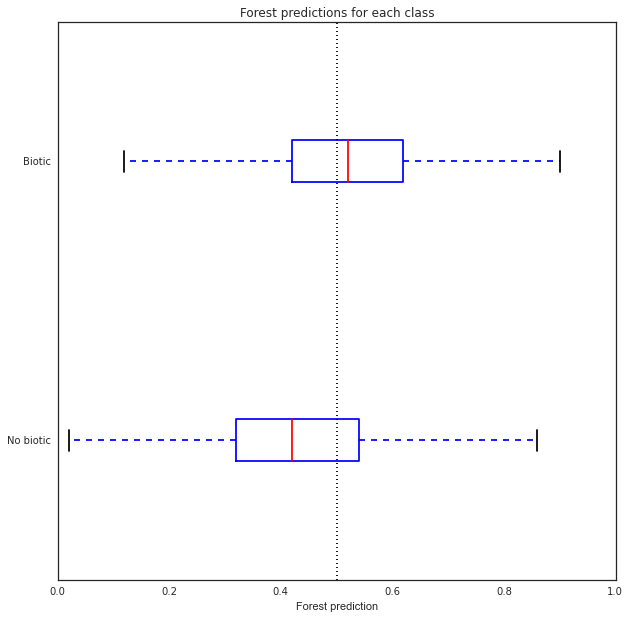

In [49]:
# run through a classifier
prediction = rfs['substrip_maxs'].predict_proba(
    features['substrip_maxs'])[:, 1]

# plotting the prediction as a graph
plt.figure(figsize=(13, 3))
plt.plot(gt_biotic, label='Ground truth')
plt.plot(prediction, label='Prediction')
plt.ylim(0, 1.1)
plt.xlabel('Time slice')
plt.legend(loc="lower right")

sorted_preds = [prediction[gt_biotic==0], prediction[gt_biotic==1]]

plt.figure(figsize=(13, 10))
plt.boxplot(sorted_preds, 0, 'b+', 0);
plt.xlim(0, 1.0)
plt.xlabel('Forest prediction')
plt.title('Forest predictions for each class')
plt.plot([0.5, 0.5], [0, 3], 'k:')
plt.gca().set_yticklabels(['No biotic', 'Biotic']);

In [ ]:


# plt.plot(gt_biotic, prediction, '.')
# plt.plot([0, 1], [0, 1], 'k--')
# plt.xlim([0.0, 1.0])
# plt.ylim([0.0, 1.0])
# plt.xlabel('Ground truth')
# plt.ylabel('Predictions')
# plt.title('ROC curve')

# plt.gca().set_aspect('equal', adjustable='box')



plt.plot(rf.feature_importances_)